<h1>Warranty budget regression<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simple-regression-models-with-pipeline" data-toc-modified-id="Simple-regression-models-with-pipeline-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simple regression models with pipeline</a></span></li><li><span><a href="#Random-forest-regressor" data-toc-modified-id="Random-forest-regressor-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Random forest regressor</a></span></li><li><span><a href="#Gradient-boosting-regressor" data-toc-modified-id="Gradient-boosting-regressor-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Gradient boosting regressor</a></span></li><li><span><a href="#XGB-regressor" data-toc-modified-id="XGB-regressor-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>XGB regressor</a></span></li><li><span><a href="#Cat-boost-regressor" data-toc-modified-id="Cat-boost-regressor-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Cat boost regressor</a></span></li></ul></div>

In [221]:
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings
warnings.simplefilter('ignore')

import xgboost
import catboost

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import (
    LogisticRegression,
    LinearRegression,
    Lasso,
    Ridge
)

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)

from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    make_scorer,
    mean_squared_error,
    mean_absolute_error
)

try:
    import phik
except:
    !pip install phik 
    
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

In [222]:
pd.options.display.float_format = '{:,.2f}'.format

In [223]:
RANDOM_STATE = 42

In [224]:
df = pd.read_csv('https://github.com/Filichkin/ML-researches/blob/main/Warranty%20bugget%20ML/train_tw.csv',
                decimal='.', sep=',')

In [225]:
df.head(5)

,id,region,dowt,trp_expert,sp_sale,uio,cpc,total_w
0,nw1,NorthWest,Certified,0.80,"11,033,450","1,777","16,102","4,798,266"
1,nw2,NorthWest,Certified,1.00,"21,202,339","1,181","11,601","6,218,265"
2,nw3,NorthWest,Certified,1.00,"24,568,778","3,746","12,409","6,986,205"
3,nw4,NorthWest,Certified,0.63,"33,605,974","3,959","11,580","14,973,266"
4,nw5,NorthWest,Certified,0.75,"22,684,320","2,390","23,977","13,427,379"


- id: dealer id;
- region: region;
- dowt: dealer warranty certification status;
- trp_expert: dealer technician certification status;
- sp_sale spare parts sales;
- uio - unit in operation;
- cpc - cost per warranty claim;
- total_w - total warranty cost,

In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          190 non-null    object 
 1   region      190 non-null    object 
 2   dowt        190 non-null    object 
 3   trp_expert  190 non-null    float64
 4   sp_sale     190 non-null    object 
 5   uio         190 non-null    object 
 6   cpc         190 non-null    object 
 7   total_w     190 non-null    object 
dtypes: float64(1), object(7)
memory usage: 12.0+ KB


In [227]:
object_col = ['sp_sale', 'uio', 'cpc', 'total_w']

In [228]:
for ob in object_col:
    df[ob] = df[ob].str.replace(' ', '').str.replace(',', '')
    df[ob] = np.array(df[ob], dtype='float')

In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          190 non-null    object 
 1   region      190 non-null    object 
 2   dowt        190 non-null    object 
 3   trp_expert  190 non-null    float64
 4   sp_sale     190 non-null    float64
 5   uio         190 non-null    float64
 6   cpc         190 non-null    float64
 7   total_w     190 non-null    float64
dtypes: float64(5), object(3)
memory usage: 12.0+ KB


In [230]:
num_col_names = df.select_dtypes(include='number').columns.tolist()

In [231]:
num_col_names

['trp_expert', 'sp_sale', 'uio', 'cpc', 'total_w']

In [232]:
df[num_col_names].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
trp_expert,190.00,0.84,0.24,0.00,0.78,0.98,1.00,1.00
sp_sale,190.00,"37,170,320.64","40,342,174.21","866,742.00","15,951,015.75","25,402,894.00","44,369,242.25","333,522,741.00"
uio,190.00,"3,629.10","2,360.16",537.00,"2,115.25","3,252.00","4,283.75","20,354.00"
cpc,190.00,"17,282.99","6,452.19","4,676.00","13,455.25","16,320.50","19,141.50","54,831.00"
total_w,190.00,"10,676,521.55","6,942,754.32","9,351.00","5,563,282.00","9,268,234.00","14,327,995.00","45,418,546.00"


In [233]:
def hist_plot(df, count_list, figsize):
    row = math.ceil(len(count_list))
    fig, axes = plt.subplots(row, 2, figsize=(12, figsize))
    plt.suptitle('Распределение по количественным признакам',
                 x=0.5,
                 y=0.9,
                 fontsize=12,
                 fontweight='bold')    
    for i, j in enumerate(count_list):
        sns.histplot(data = df, x=j, ax=axes[i, 0],
                     kde=True,
                     line_kws = {'linestyle':'dashed',
                                 'linewidth':'1'},
                     color='#9BCD9B')
        sns.boxplot(data = df, x=j, ax=axes[i, 1],
                     color='#9BCD9B',
                     linewidth=0.5,
                     width=0.5,
                     medianprops={"color": "r", "linewidth": 1})

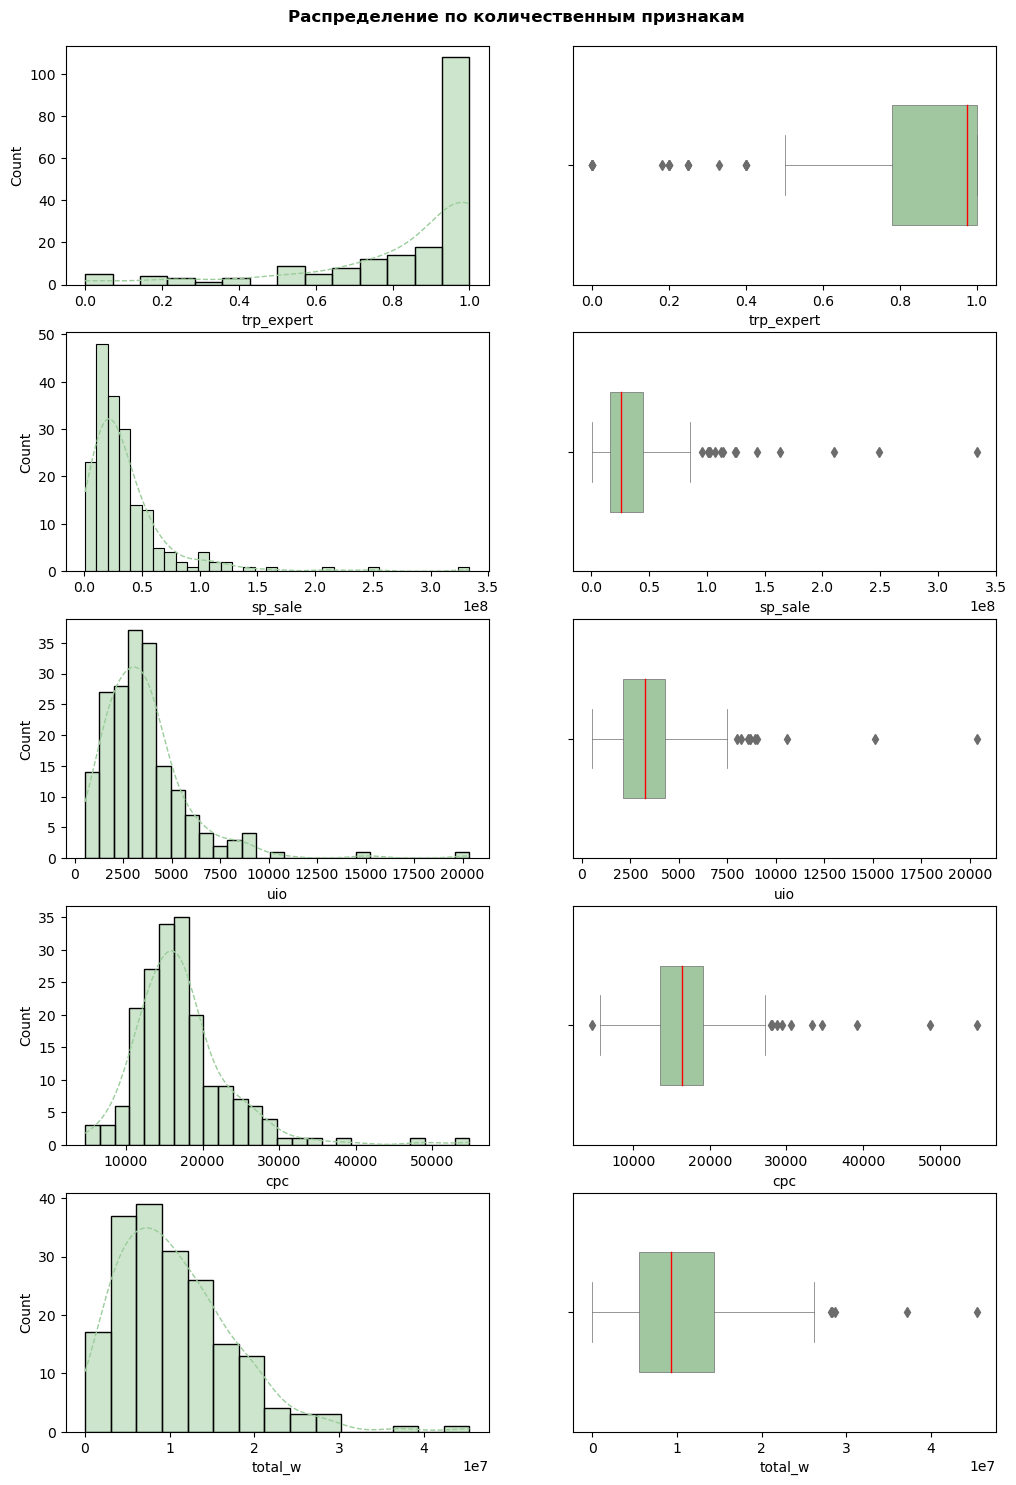

In [234]:
hist_plot(df, num_col_names, 18)

Избавимся от выбросов:

In [235]:
new_df = df.query('sp_sale < 200000000 and total_w < 27000000 and cpc < 30000 and uio < 15000')

In [236]:
new_df.reset_index(drop=True, inplace=True)

In [237]:
new_df.shape

(176, 8)

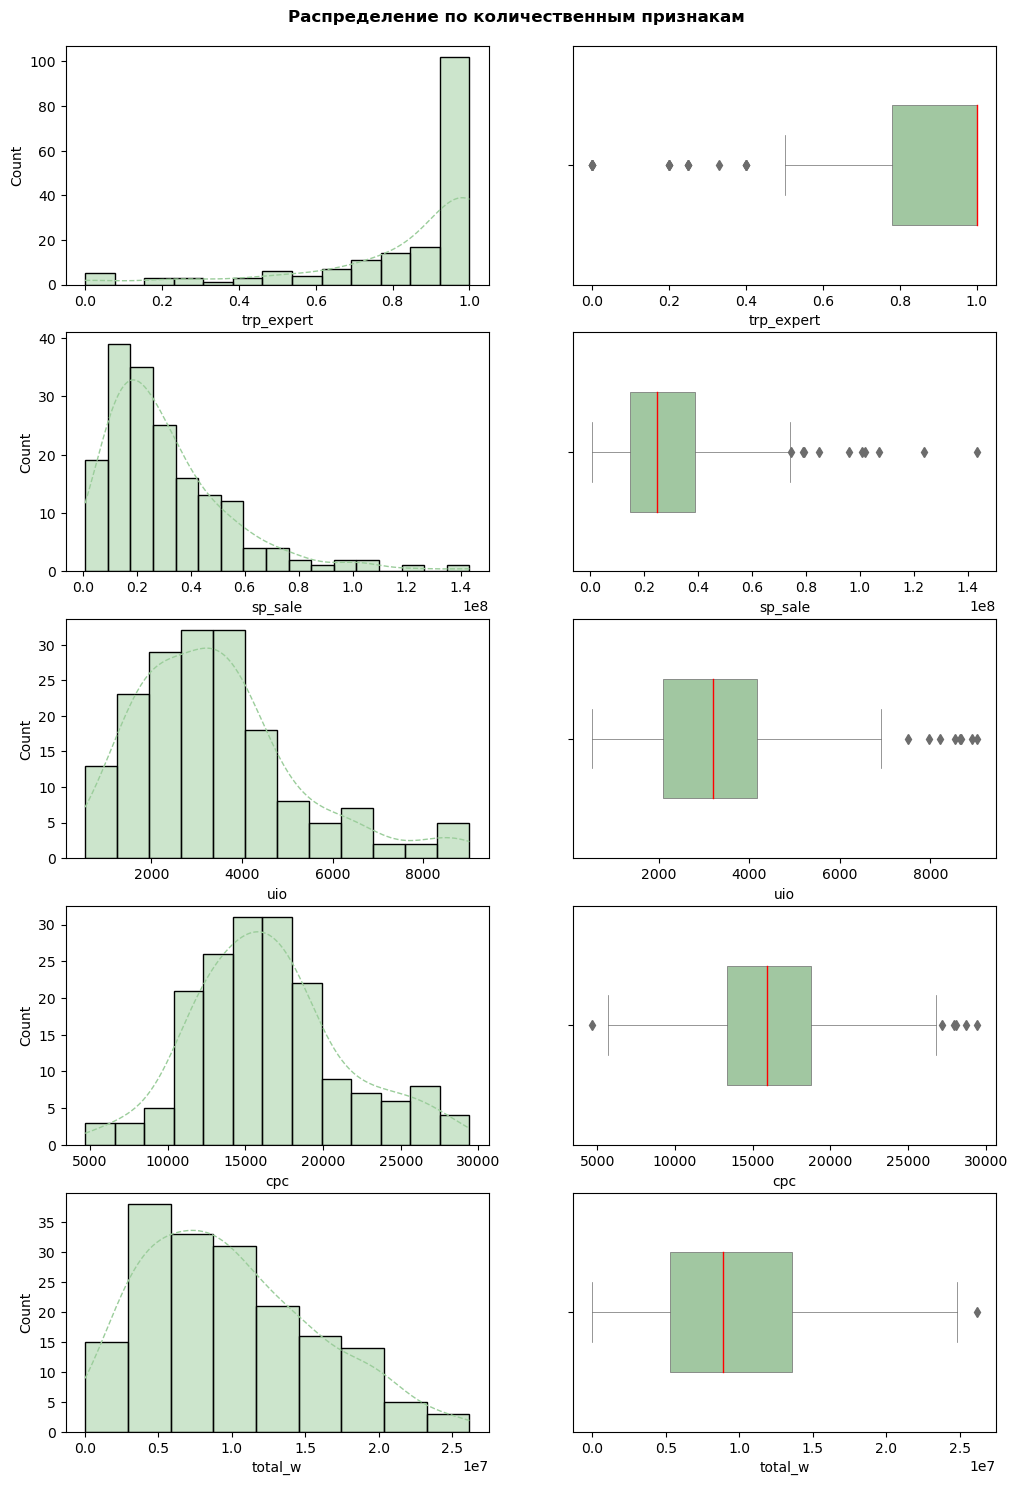

In [238]:
hist_plot(new_df, num_col_names, 18)

In [239]:
cat_col_names = df.loc[:, ~df.columns.isin(
    ['id'])].select_dtypes(exclude='number').columns.tolist()

In [240]:
cat_col_names

['region', 'dowt']

In [241]:
def cat_plot_pie(df, kat_list):
    row = math.ceil(len(kat_list)/2)
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))
    plt.suptitle('Распределение по категоральным признакам',
                 x=0.5,
                 y=1.1,
                 fontsize=10,
                 fontweight='bold')
    k = 0
    for c in range(2):
        ax[c].pie(df[kat_list[k]].dropna().value_counts(),
                    labels = df[kat_list[k]].dropna().value_counts().index,
                    startangle=90,
                    autopct = '%1.1f%%',
                    colors=sns.color_palette('Set3')
                        )
        ax[c].set_title(kat_list[k])
        k += 1
        if k==len(kat_list):
            break

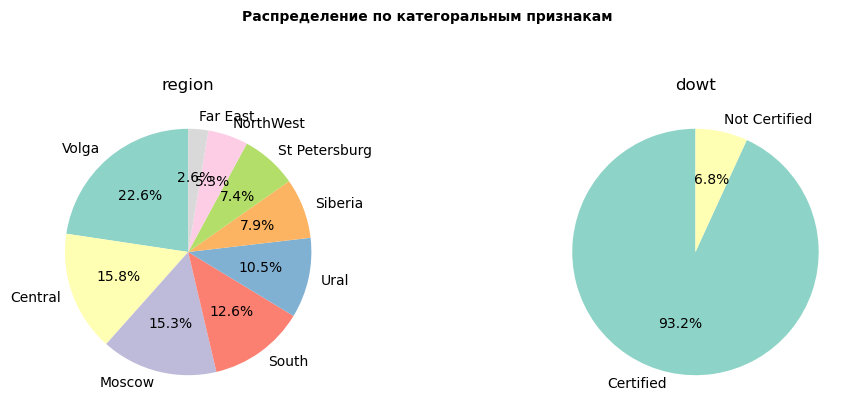

In [242]:
cat_plot_pie(df, cat_col_names)

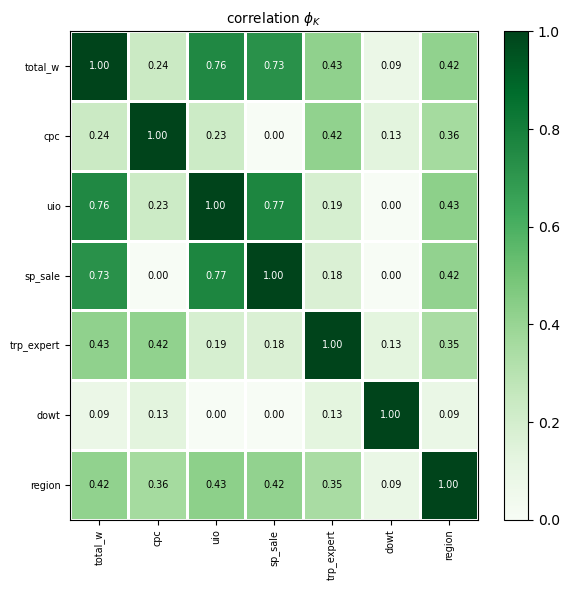

In [243]:
phik_overview = phik_matrix(new_df.loc[:, ~new_df.columns.isin(['id'])], interval_cols=num_col_names, verbose=False)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=0.7,
    figsize=(6, 6)
) 

### Simple regression models with pipeline

In [244]:
X_train = new_df.drop(['id', 'total_w'], axis=1)
y_train = new_df['total_w']

In [245]:
ohe_columns = ['region', 'dowt']
num_columns = ['trp_expert', 'sp_sale', 'uio', 'cpc']

In [246]:
ohe_pipe = Pipeline(
    [(
        'simpleImputer_ohe',
        SimpleImputer(
            missing_values=np.nan,
            strategy='most_frequent'
        )
    ),
     (
         'ohe',
         OneHotEncoder(
             drop='first',
             categories='auto',
             handle_unknown='ignore',
             sparse=False
         )
     )
    ]
)

In [247]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [248]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression()
    )
])

In [249]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 21),
        'models__min_samples_split': range(2, 21),
        'models__max_features': range(2, 21),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [SVR()],
        'models__kernel' : ['rbf','sigmoid', 'linear', 'poly'],
        'models__C': [0.01, 0.1, 1, 2, 5, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [LinearRegression()],  
        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [Lasso(random_state = RANDOM_STATE), Ridge(random_state = RANDOM_STATE)],  
        'models__alpha': [0, 0.2, 0.25, 0.3, 0.5, 0.75, 0.8, 0.9, 1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [250]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv = 5,
    n_iter=10,
    scoring = 'neg_mean_absolute_error',
    random_state = RANDOM_STATE,
    n_jobs = -1
)

In [251]:
randomized_search.fit(X_train, y_train)

/Users/alexfil/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alexfil/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alexfil/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alexfil/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/alexfil/anaconda3/lib/python3.11/site-packages/sk

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['region',
                                                                                'dowt']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['trp_expert',
                                                                                'sp_sale',
                                                                                '...
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [Lasso(random_state=42),
                                                    Ridge(random_state=42)],
                                         'models__alpha': [0, 0.2, 0.25, 0.3,
                                                           0.5, 0.75, 0.8, 0.9,
                                                           1],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='neg_mean_absolute_error')

In [252]:
print('Best model with parameters:\n\n', randomized_search.best_estimator_)
print ('Best model metric in cross-validation:', randomized_search.best_score_)

Best model with parameters:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['region', 'dowt']),
                                                 ('num', MinMaxScaler(),
                                                  ['trp_expert', 'sp_sale',
                             

In [253]:
result = pd.DataFrame(randomized_search.cv_results_)
result = result[
    ['rank_test_score', 'param_models', 'mean_test_score', 'params']
    ].sort_values('rank_test_score') 

In [254]:
result

,rank_test_score,param_models,mean_test_score,params
7,1,"DecisionTreeRegressor(max_depth=6, max_feature...","-3,273,344.84","{'preprocessor__num': MinMaxScaler(), 'models_..."
4,2,"DecisionTreeRegressor(max_depth=6, max_feature...","-3,299,091.94","{'preprocessor__num': MinMaxScaler(), 'models_..."
1,3,"DecisionTreeRegressor(max_depth=6, max_feature...","-3,402,089.17","{'preprocessor__num': 'passthrough', 'models__..."
2,4,"DecisionTreeRegressor(max_depth=6, max_feature...","-3,595,766.09","{'preprocessor__num': 'passthrough', 'models__..."
5,5,"DecisionTreeRegressor(max_depth=6, max_feature...","-3,684,378.25","{'preprocessor__num': MinMaxScaler(), 'models_..."
6,6,"DecisionTreeRegressor(max_depth=6, max_feature...","-3,754,349.44","{'preprocessor__num': 'passthrough', 'models__..."
9,7,"DecisionTreeRegressor(max_depth=6, max_feature...","-4,018,303.66","{'preprocessor__num': 'passthrough', 'models__..."
8,8,"DecisionTreeRegressor(max_depth=6, max_feature...","-4,022,246.56","{'preprocessor__num': 'passthrough', 'models__..."
3,9,"DecisionTreeRegressor(max_depth=6, max_feature...","-4,072,415.57","{'preprocessor__num': StandardScaler(), 'model..."
0,10,"DecisionTreeRegressor(max_depth=6, max_feature...","-4,186,489.95","{'preprocessor__num': StandardScaler(), 'model..."


In [255]:
best_model_preprocessor = randomized_search.best_estimator_['preprocessor']
best_model = randomized_search.best_estimator_['models']

In [256]:
X_train_p = pd.DataFrame(
    best_model_preprocessor.fit_transform(X_train),
    columns=best_model_preprocessor.get_feature_names_out())

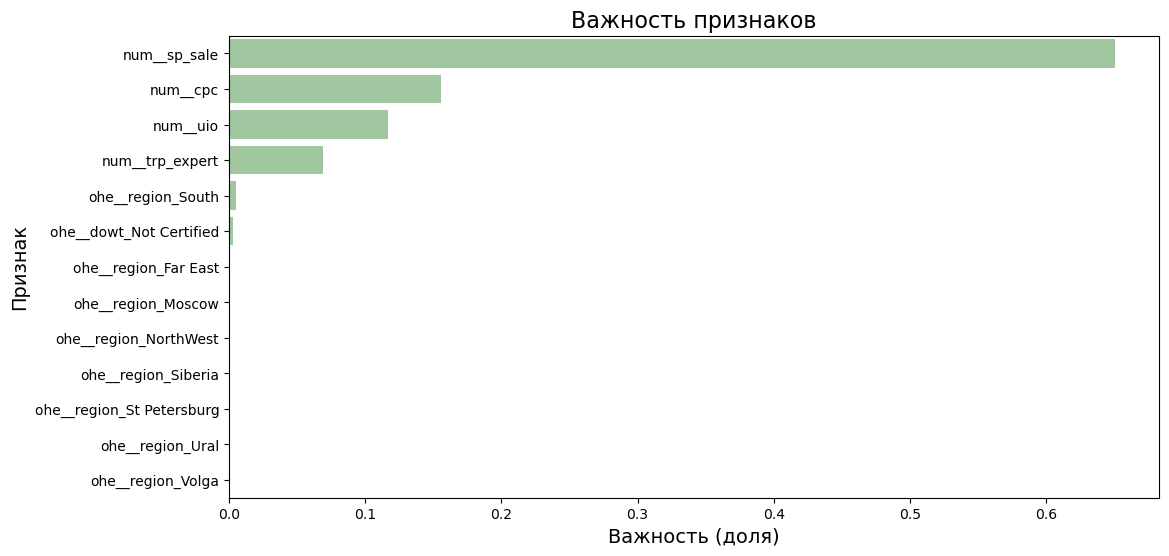

In [257]:
feature_importances = pd.DataFrame(
    {
        'Feature': X_train_p.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.barplot(data = feature_importances, x='Importance', y='Feature',
                     color='#9BCD9B')
ax.set_title('Важность признаков', fontsize=16)
ax.set_xlabel('Важность (доля)', fontsize=14)
ax.set_ylabel('Признак', fontsize=14)
plt.show()

### Random forest regressor

In [258]:
x = new_df.drop(['id', 'region', 'dowt', 'total_w'], axis=1)
y = new_df['total_w']

In [259]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=RANDOM_STATE)

In [260]:
x_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [261]:
def bootstrap_metric(x, y, metric_fn, samples_cnt=1000, alpha=0.05, random_state=RANDOM_STATE):
    size = len(x)
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)

        x_boot = x[poses]
        y_boot = y[poses]

        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val

    return b_metric

In [262]:
models_rf = {}

models_rf["DT"] = GridSearchCV(
    DecisionTreeRegressor(),
    {"max_depth": [1, 3, 5, 7, 10], "min_samples_leaf": [1, 3, 5, 10]},
)

for n_estimators in [3, 5, 10, 50, 100, 150, 250]:
    models_rf[f"RF{n_estimators}"] = RandomForestRegressor(
        n_estimators=n_estimators, random_state=42, n_jobs=-1
    )

In [263]:
def train_and_test_regressor(models, x_train, y_train, x_test, y_test, verb=True):
    boot_scores = {}
    for name, model in models.items():
        model.fit(x_train, y_train)  # train the model
        y_pred = model.predict(x_test)  # get predictions
        boot_scores[name] = bootstrap_metric(  # calculate bootstrap score from function
            y_test,
            y_pred,
            metric_fn=lambda x, y: mean_absolute_error(y_true=x, y_pred=y),
        )
        if verb:
            print(f"Fitted {name} with bootstrap score {boot_scores[name].mean():.3f}")

    results = pd.DataFrame(boot_scores)
    results = results.melt(
        value_vars=results.columns, value_name="mae", var_name="model"
    )
    return results


results_rf = train_and_test_regressor(models_rf, x_train, y_train, x_test, y_test)

Fitted DT with bootstrap score 3684943.832
Fitted RF3 with bootstrap score 2977186.107
Fitted RF5 with bootstrap score 2930098.150
Fitted RF10 with bootstrap score 3049899.943
Fitted RF50 with bootstrap score 3020871.899
Fitted RF100 with bootstrap score 2970624.780
Fitted RF150 with bootstrap score 2961012.514
Fitted RF250 with bootstrap score 2967714.137


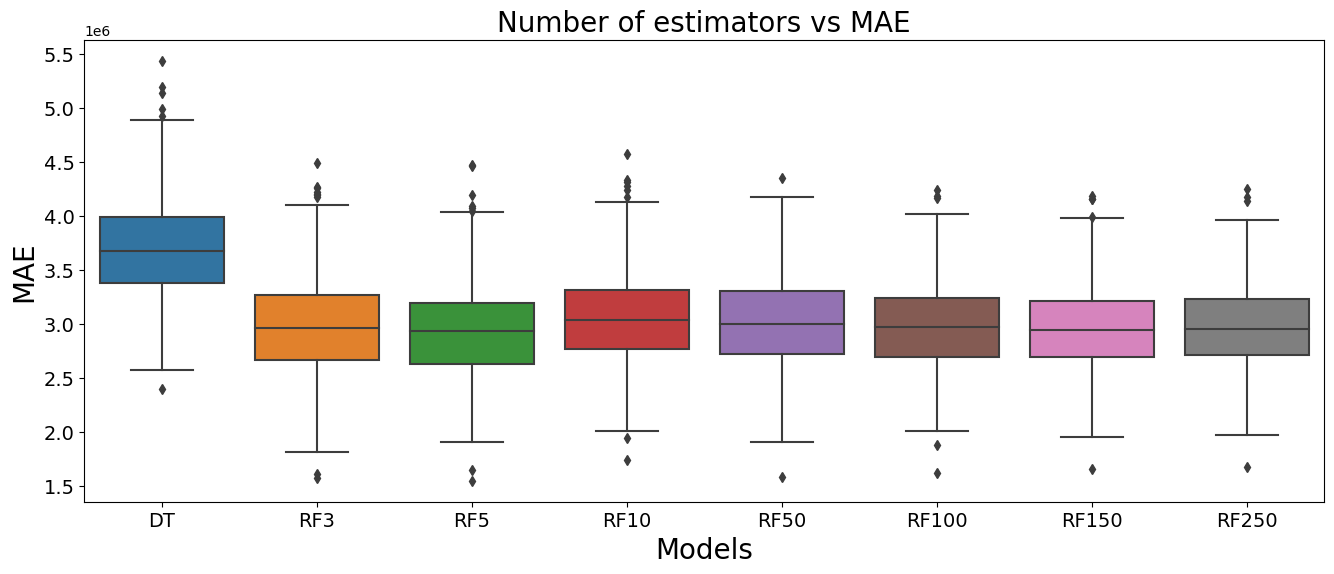

In [264]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=results_rf, y="mae", x="model")
plt.ylabel("MAE", size=20)
plt.xlabel("Models", size=20)
plt.title("Number of estimators vs MAE", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

In [265]:
dt_depth = {}
rf_depth = {}

for depth in range(1, 10, 2):
    dt_depth[depth] = DecisionTreeRegressor(max_depth=depth, random_state=RANDOM_STATE)

    rf_depth[depth] = RandomForestRegressor(
        n_estimators=150, max_depth=depth, random_state=RANDOM_STATE, n_jobs=-1
    )  

dt_res = train_and_test_regressor(
    dt_depth, x_train, y_train, x_test, y_test, verb=False
)
rf_res = train_and_test_regressor(
    rf_depth, x_train, y_train, x_test, y_test, verb=False
)

dt_res = dt_res.rename(columns={"model": "tree_depth"})
rf_res = rf_res.rename(columns={"model": "tree_depth"})
dt_res["model"] = "DT"
rf_res["model"] = "RF"
depth_res = pd.concat((dt_res, rf_res))

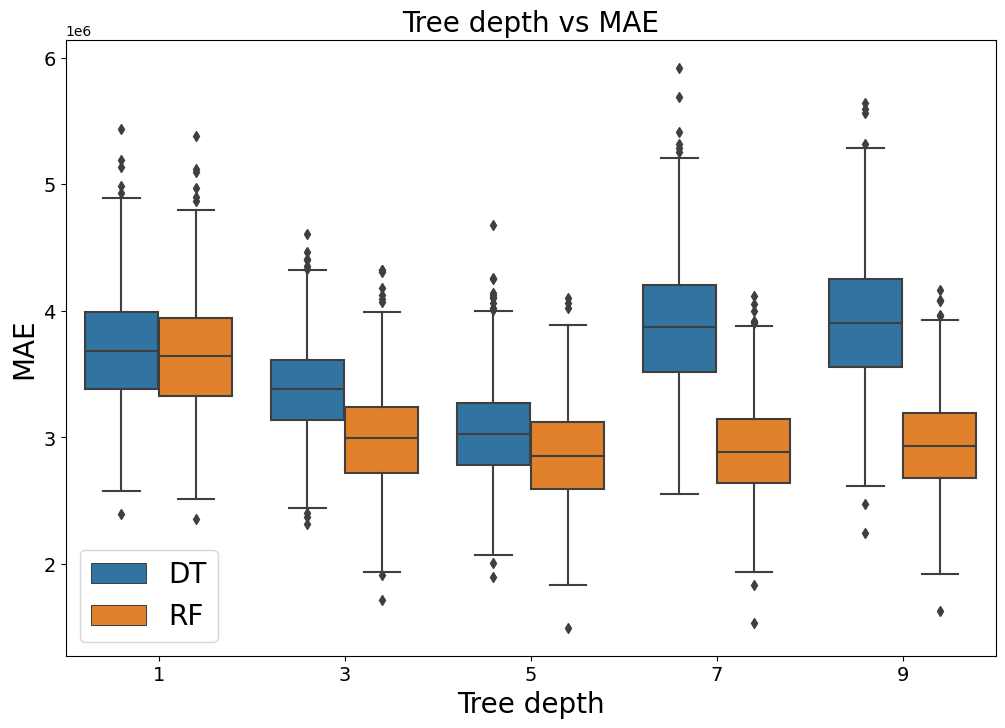

In [266]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=depth_res, x="tree_depth", y="mae", hue="model")
plt.xlabel("Tree depth", size=20)
plt.ylabel("MAE", size=20)
plt.title("Tree depth vs MAE", size=20)
plt.legend(fontsize=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

In [267]:
dt_models_min_samples = {}
rf_models_min_samples = {}

for mn_sm in [1, 3, 5, 7, 10]:
    dt_models_min_samples[mn_sm] = DecisionTreeRegressor(
        max_depth=None, min_samples_leaf=mn_sm, random_state=RANDOM_STATE
    )

    rf_models_min_samples[mn_sm] = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        min_samples_leaf=mn_sm,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )  

dt_results_mn_samples = train_and_test_regressor(
    dt_models_min_samples, x_train, y_train, x_test, y_test
)
rf_results_mn_samples = train_and_test_regressor(
    rf_models_min_samples, x_train, y_train, x_test, y_test
)

dt_results_mn_samples = dt_results_mn_samples.rename(columns={"model": "min_samples"})
rf_results_mn_samples = rf_results_mn_samples.rename(columns={"model": "min_samples"})
dt_results_mn_samples["model"] = "DT"
rf_results_mn_samples["model"] = "RF"
leaf_res = pd.concat((dt_results_mn_samples, rf_results_mn_samples))

Fitted 1 with bootstrap score 4145741.262
Fitted 3 with bootstrap score 3317001.026
Fitted 5 with bootstrap score 3728228.539
Fitted 7 with bootstrap score 3572984.822
Fitted 10 with bootstrap score 3454178.059
Fitted 1 with bootstrap score 2970624.780
Fitted 3 with bootstrap score 2917207.895
Fitted 5 with bootstrap score 3014746.838
Fitted 7 with bootstrap score 3089828.032
Fitted 10 with bootstrap score 3156422.778


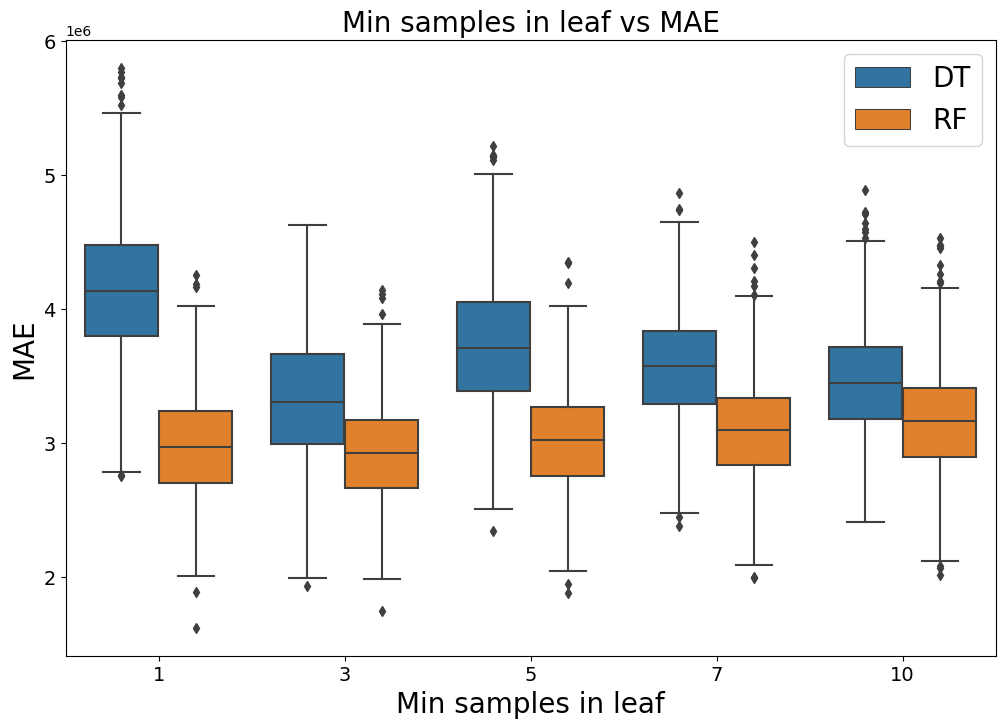

In [268]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=leaf_res, x="min_samples", y="mae", hue="model")
plt.xlabel("Min samples in leaf", size=20)
plt.ylabel("MAE", size=20)
plt.title("Min samples in leaf vs MAE", size=20)
plt.legend(fontsize=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

### Gradient boosting regressor

In [296]:
models = {}

# make pipeline 
models["LinReg"] = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

models["RF"] = RandomForestRegressor(
    n_estimators=150,  
    max_depth=5,
    min_samples_leaf=3,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

models["GradientBoosting"] = GradientBoostingRegressor(
    learning_rate=0.05,  
    n_estimators=150,  
    random_state=RANDOM_STATE,
)

results_boost = train_and_test_regressor(models, x_train, y_train, x_test, y_test)

Fitted LinReg with bootstrap score 2963679.721
Fitted RF with bootstrap score 2896651.624
Fitted GradientBoosting with bootstrap score 2807590.486


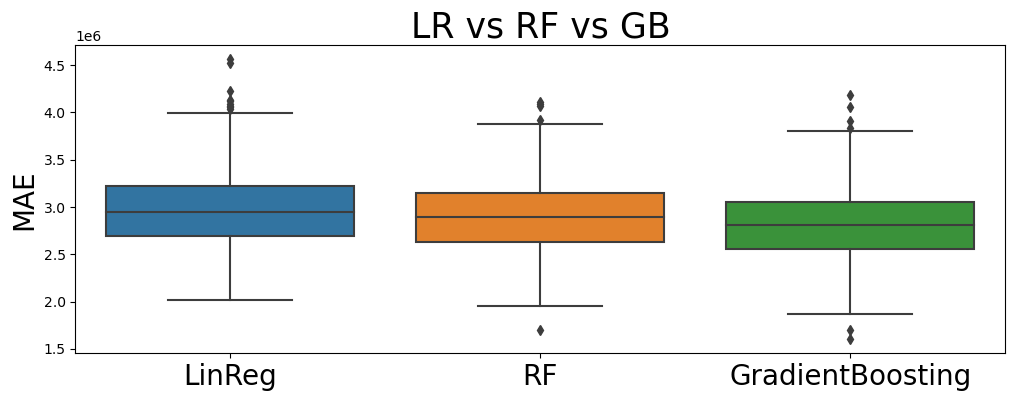

In [295]:
plt.figure(figsize=(12, 4))
ax = sns.boxplot(data=results_boost, y="mae", x="model")
plt.xlabel("", size=20)
plt.ylabel("MAE", size=20)
plt.title("LR vs RF vs GB", size=25)
plt.xticks(size=20)
plt.show()

In [271]:
gbtree = GradientBoostingRegressor(
    n_estimators=150, learning_rate=1
)
gbtree.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=1, n_estimators=150)

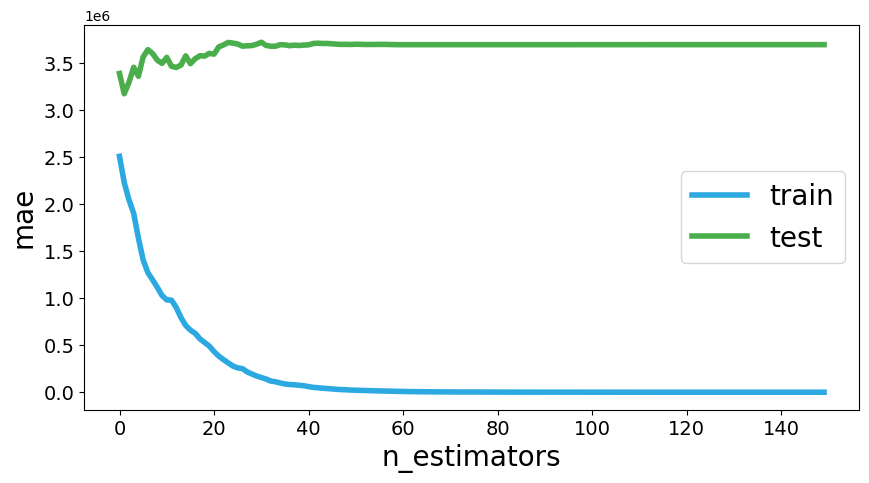

In [272]:
error_train = []
error_test = []
for it, (y_train_pred, y_test_pred) in enumerate(
    zip(gbtree.staged_predict(x_train), gbtree.staged_predict(x_test))
):
    ertr = mean_absolute_error(y_true=y_train, y_pred=y_train_pred)
    error_train.append(ertr)
    erte = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    error_test.append(erte)


plt.figure(figsize=(10, 5))
plt.plot(error_train, label="train", c="#2DA9E1", linewidth=4)
plt.plot(error_test, label="test", c="#4AAE4D", linewidth=4)
plt.xlabel("n_estimators", size=20)
plt.ylabel("mae", size=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=20)
plt.show()

In [273]:
gbtrees_list = []

for lr in [1, 0.5, 0.1, 0.05, 0.01]:
    gbtree = GradientBoostingRegressor(n_estimators=150, learning_rate=lr)
    gbtree.fit(x_train, y_train)
    gbtrees_list.append(gbtree)

In [274]:
gbtrees_list

[GradientBoostingRegressor(learning_rate=1, n_estimators=150),
 GradientBoostingRegressor(learning_rate=0.5, n_estimators=150),
 GradientBoostingRegressor(n_estimators=150),
 GradientBoostingRegressor(learning_rate=0.05, n_estimators=150),
 GradientBoostingRegressor(learning_rate=0.01, n_estimators=150)]

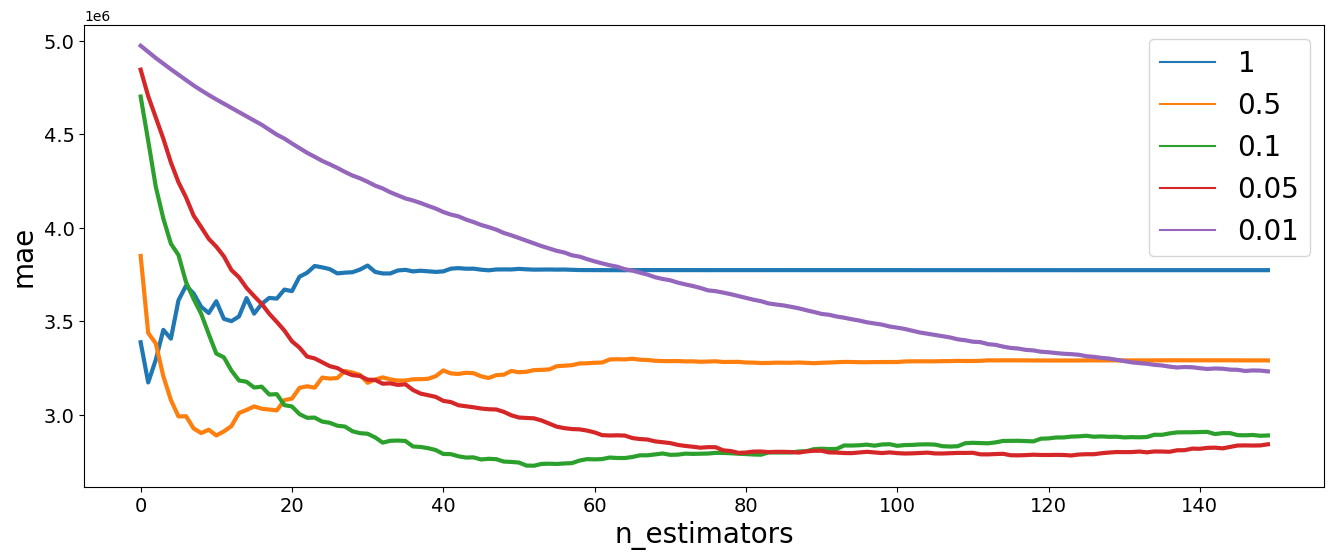

In [275]:
lr = []
step = []
mae = []
for gb_tree in gbtrees_list:
    for it, y_test_pred in enumerate(gb_tree.staged_predict(x_test)):
        erte = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
        mae.append(erte)
        lr.append(str(gb_tree.learning_rate))
        step.append(it)

df = pd.DataFrame({"learning_rate": lr, "n_estimators": step, "mae": mae})

plt.figure(figsize=(16, 6))
sns.lineplot(data=df, x="n_estimators", y="mae", hue="learning_rate", lw=3)
plt.xlabel("n_estimators", size=20)
plt.ylabel("mae", size=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=20)
plt.show()

In [276]:
x_learn, x_valid, y_learn, y_valid = train_test_split(x_train, y_train, random_state=RANDOM_STATE)

In [277]:
x_learn.reset_index(drop=True, inplace=True)
x_valid.reset_index(drop=True, inplace=True)
y_learn.reset_index(drop=True, inplace=True)
y_valid.reset_index(drop=True, inplace=True)

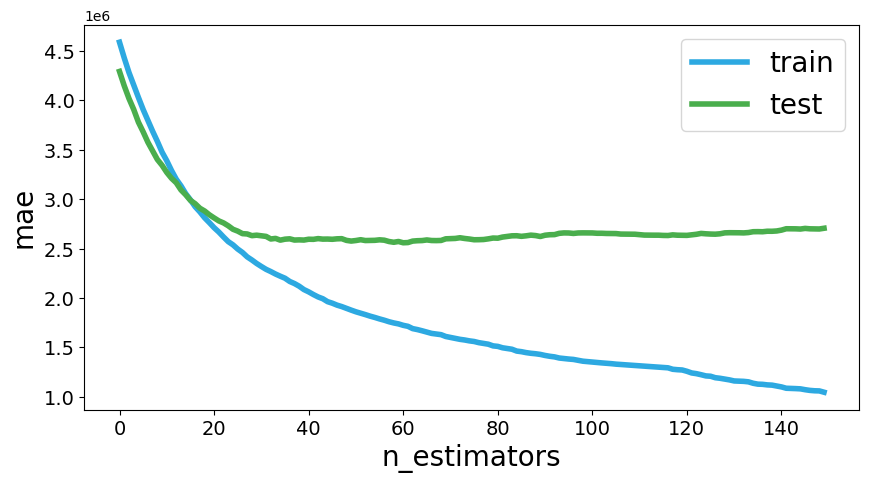

In [278]:
gbtree = GradientBoostingRegressor(n_estimators=150, learning_rate=0.05)
gbtree.fit(x_learn, y_learn)

error_train = []
error_test = []
for it, (y_learn_pred, y_valid_pred) in enumerate(
    zip(gbtree.staged_predict(x_learn), gbtree.staged_predict(x_valid))
):
    ertr = mean_absolute_error(y_true=y_learn, y_pred=y_learn_pred)
    error_train.append(ertr)
    erte = mean_absolute_error(y_true=y_valid, y_pred=y_valid_pred)
    error_test.append(erte)

plt.figure(figsize=(10, 5))
plt.plot(error_train, label="train", c="#2DA9E1", linewidth=4)
plt.plot(error_test, label="test", c="#4AAE4D", linewidth=4)
plt.xlabel("n_estimators", size=20)
plt.ylabel("mae", size=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=20)
plt.show()

In [279]:
models = {}
for depth in (1, 2, 3, 5, 10):
    models[depth] = GradientBoostingRegressor(
        n_estimators=150, learning_rate=0.05, max_depth=depth, random_state=RANDOM_STATE
    )

depth_boost = train_and_test_regressor(models, x_learn, y_learn, x_valid, y_valid)

Fitted 1 with bootstrap score 2564594.643
Fitted 2 with bootstrap score 2557422.843
Fitted 3 with bootstrap score 2677154.840
Fitted 5 with bootstrap score 3000260.205
Fitted 10 with bootstrap score 3314361.721


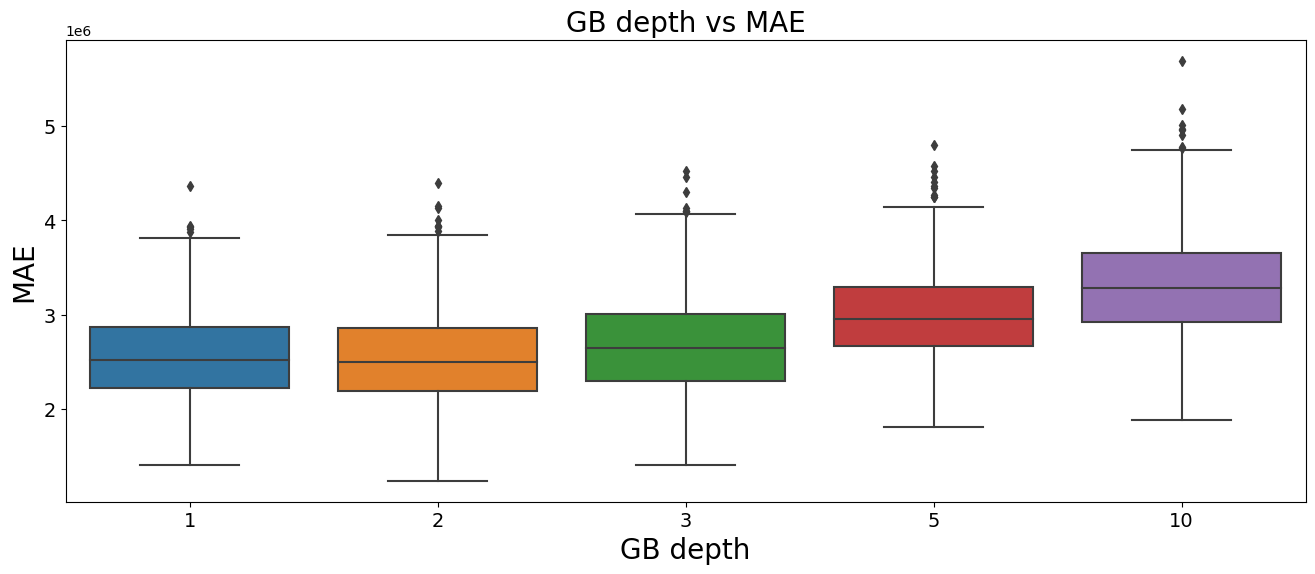

In [280]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(data=depth_boost, y="mae", x="model")
plt.xlabel("GB depth", size=20)
plt.ylabel("MAE", size=20)
plt.title("GB depth vs MAE", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

In [281]:
models = {}
for min_samples_leaf in (1, 3, 5, 7, 9, 11):
    models[min_samples_leaf] = GradientBoostingRegressor(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=2,
        min_samples_leaf=min_samples_leaf,
        random_state=RANDOM_STATE,
    )

mns_boost = train_and_test_regressor(models, x_learn, y_learn, x_valid, y_valid)

Fitted 1 with bootstrap score 2557422.843
Fitted 3 with bootstrap score 2535912.632
Fitted 5 with bootstrap score 2747043.715
Fitted 7 with bootstrap score 2858982.918
Fitted 9 with bootstrap score 2617161.220
Fitted 11 with bootstrap score 2486329.883


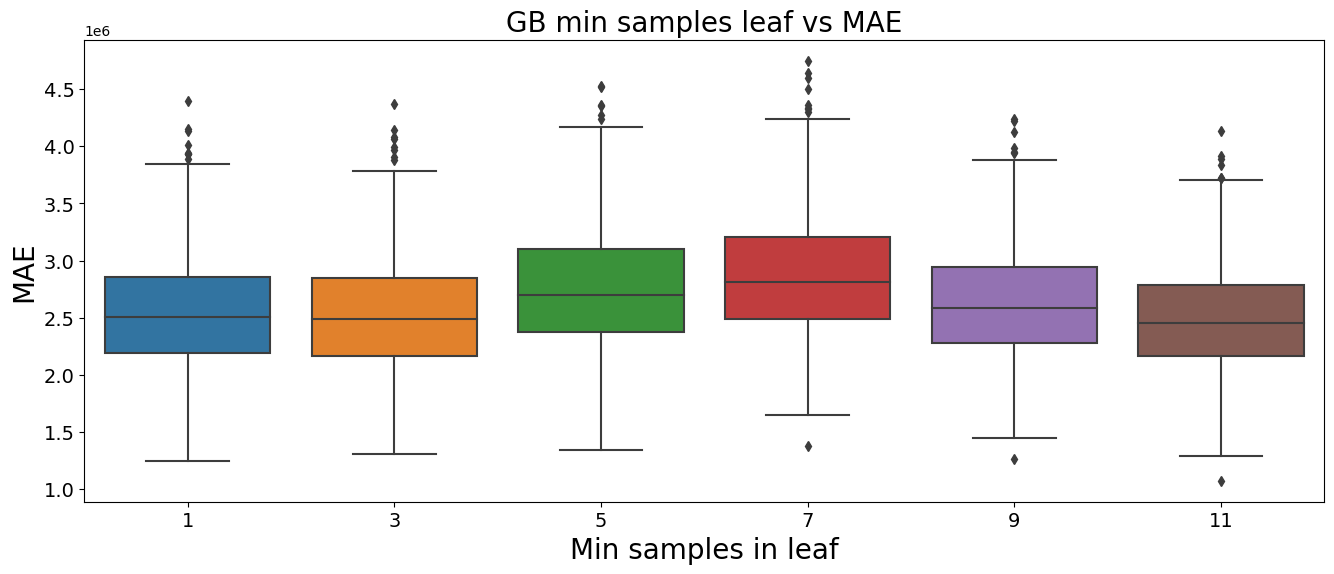

In [282]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(data=mns_boost, y="mae", x="model")
plt.xlabel("Min samples in leaf", size=20)
plt.ylabel("MAE", size=20)
plt.title("GB min samples leaf vs MAE", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

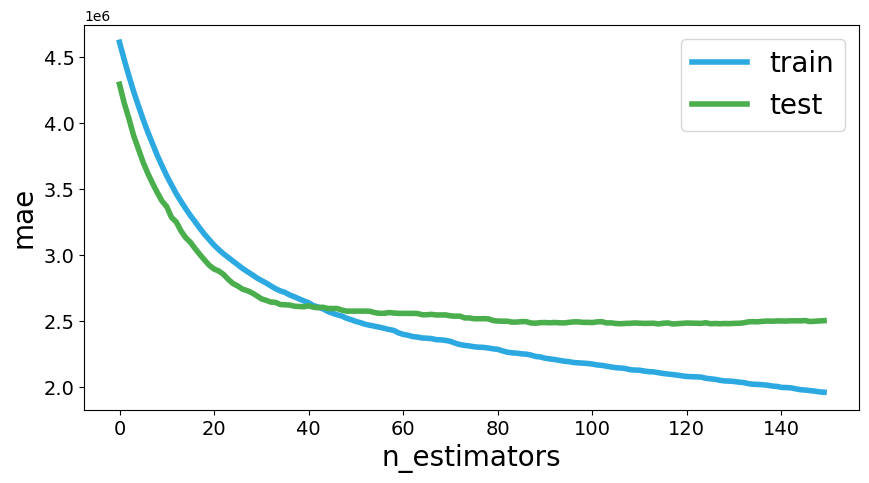

In [283]:
gbtree = GradientBoostingRegressor(
    n_estimators=150,
    max_depth=2,
    min_samples_leaf=11,
    learning_rate=0.05,
    random_state=RANDOM_STATE,
)
gbtree.fit(x_learn, y_learn)

error_train = []
error_test = []
for it, (y_learn_pred, y_valid_pred) in enumerate(
    zip(gbtree.staged_predict(x_learn), gbtree.staged_predict(x_valid))
):
    ertr = mean_absolute_error(y_true=y_learn, y_pred=y_learn_pred)
    error_train.append(ertr)
    erte = mean_absolute_error(y_true=y_valid, y_pred=y_valid_pred)
    error_test.append(erte)

plt.figure(figsize=(10, 5))
plt.plot(error_train, label="train", c="#2DA9E1", linewidth=4)
plt.plot(error_test, label="test", c="#4AAE4D", linewidth=4)
plt.xlabel("n_estimators", size=20)
plt.ylabel("mae", size=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=20)
plt.show()

In [284]:
models = {}

models["LinReg"] = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

models["RF"] = RandomForestRegressor(
    n_estimators=150, max_depth=None, min_samples_leaf=11, n_jobs=-1, random_state=RANDOM_STATE
)

models["GBR"] = GradientBoostingRegressor(
    learning_rate=0.05, n_estimators=150, random_state=RANDOM_STATE
)

models["GBR tuned"] = GradientBoostingRegressor(
    learning_rate=0.05,
    n_estimators=150,
    max_depth=2,
    min_samples_leaf=11,
    random_state=RANDOM_STATE,
)

tuned_boost = train_and_test_regressor(models, x_learn, y_learn, x_valid, y_valid)

Fitted LinReg with bootstrap score 3192530.153
Fitted RF with bootstrap score 2631522.415
Fitted GBR with bootstrap score 2677154.840
Fitted GBR tuned with bootstrap score 2486329.883


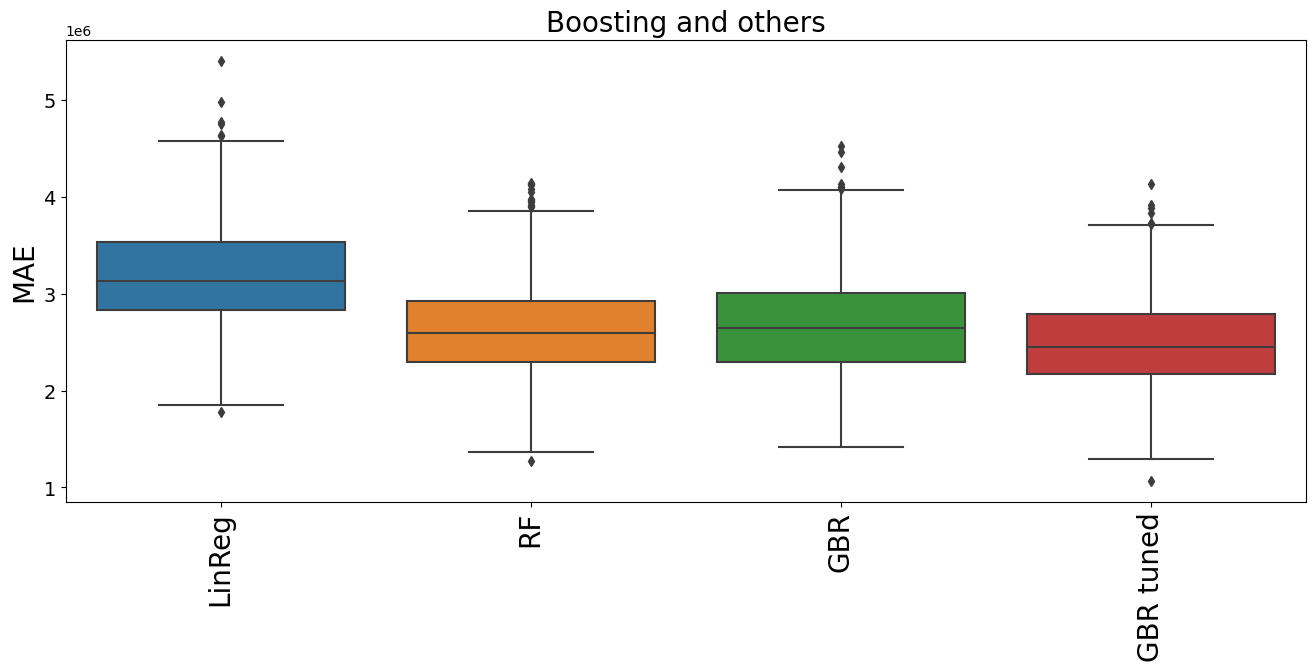

In [285]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(data=tuned_boost, y="mae", x="model")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MAE", size=20)
plt.title("Boosting and others", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xticks(fontsize=20)
plt.show()

### XGB regressor

In [286]:
models_add = {}
models_add["xgb"] = xgboost.XGBRegressor(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=2,
    random_state=RANDOM_STATE,
    min_child_weight=None,  # not exact analogue for min_samples_leaf
    n_jobs=-1,  # can be constructed in parrallel, much!!! faster)
    objective="reg:squarederror",
)

xgb_add = train_and_test_regressor(models_add, x_learn, y_learn, x_valid, y_valid)

Fitted xgb with bootstrap score 2567754.702


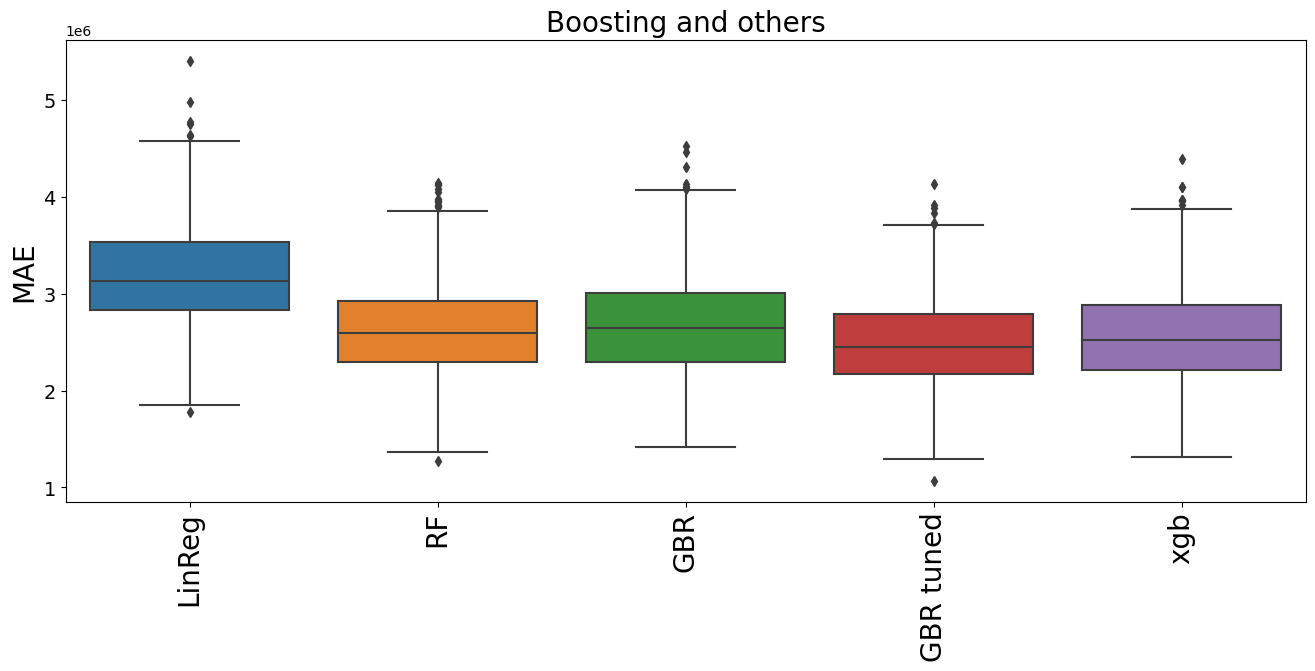

In [287]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(data=pd.concat([tuned_boost, xgb_add]), y="mae", x="model")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MAE", size=20)
plt.title("Boosting and others", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xticks(size=20)
plt.show()

In [288]:
models = {}
for min_child_weight in (1, 2, 3, 5, 7, 9, 11, 13, 15):
    models[f"xGB_mnw{min_child_weight}"] = xgboost.XGBRegressor(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=2,
        random_state=RANDOM_STATE,
        min_child_weight=min_child_weight,
        n_jobs=-1,
        objective="reg:squarederror",
    )

xgb_mw = train_and_test_regressor(models, x_learn, y_learn, x_valid, y_valid)

Fitted xGB_mnw1 with bootstrap score 2567754.702
Fitted xGB_mnw2 with bootstrap score 2607870.114
Fitted xGB_mnw3 with bootstrap score 2539512.628
Fitted xGB_mnw5 with bootstrap score 2578585.685
Fitted xGB_mnw7 with bootstrap score 2691434.062
Fitted xGB_mnw9 with bootstrap score 2597783.925
Fitted xGB_mnw11 with bootstrap score 2462190.172
Fitted xGB_mnw13 with bootstrap score 2551336.361
Fitted xGB_mnw15 with bootstrap score 2715210.144


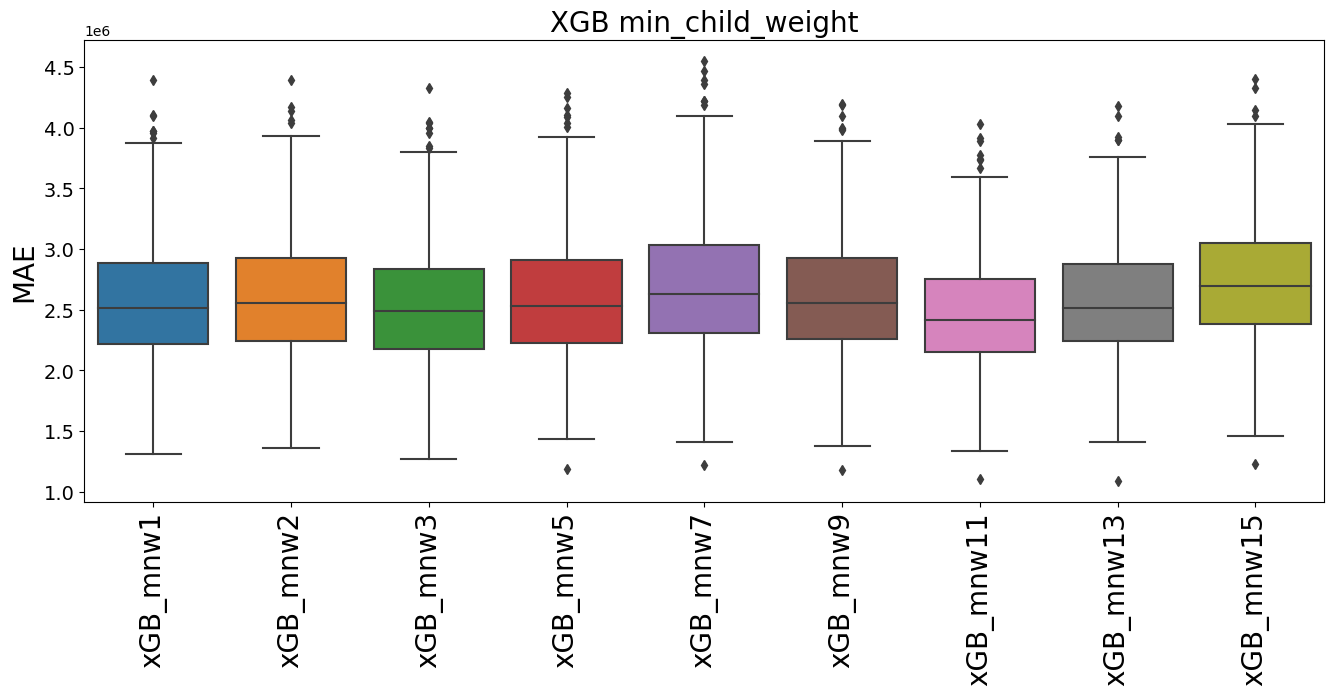

In [289]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(data=xgb_mw, y="mae", x="model")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MAE", size=20)
plt.title("XGB min_child_weight", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xticks(size=20)
plt.show()

In [290]:
models_add2 = {}
models_add2["xgb_mcw"] = xgboost.XGBRegressor(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=2,
    random_state=RANDOM_STATE,
    min_child_weight=11,
    n_jobs=-1,
    objective="reg:squarederror",
)

xgb_add2 = train_and_test_regressor(models_add2, x_learn, y_learn, x_valid, y_valid)

Fitted xgb_mcw with bootstrap score 2462190.172


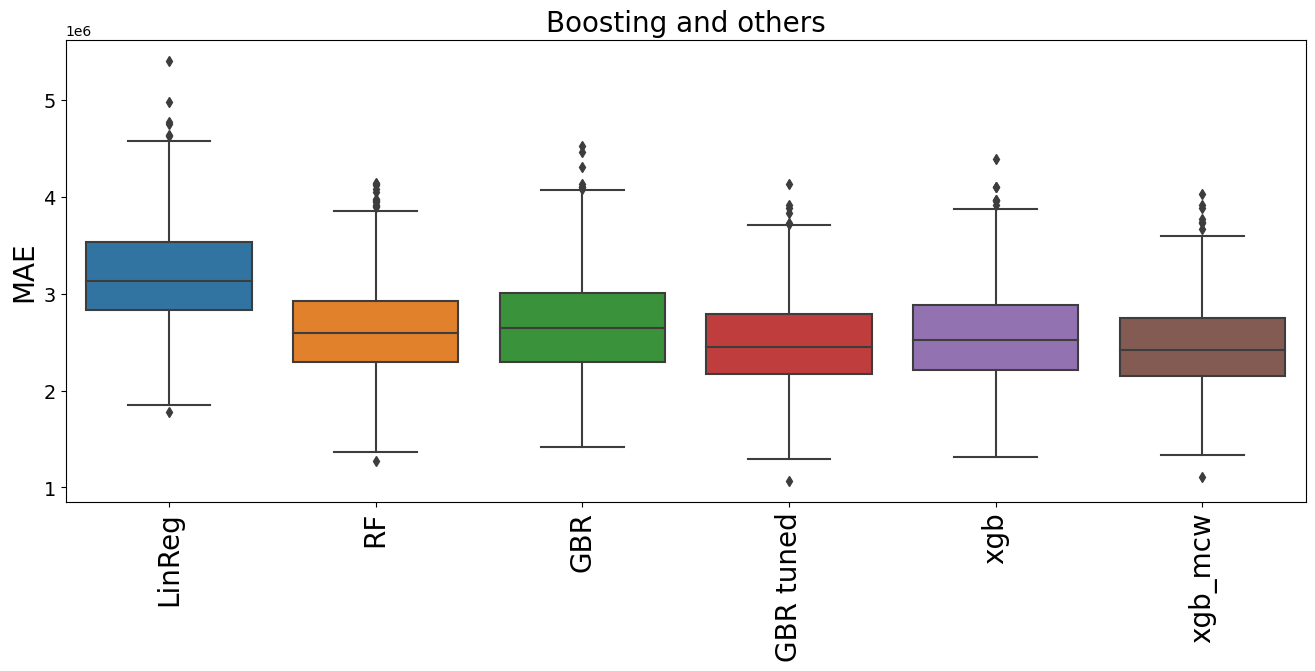

In [291]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(data=pd.concat([tuned_boost, xgb_add, xgb_add2]), y="mae", x="model")
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MAE", size=20)
plt.title("Boosting and others", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xticks(size=20)
plt.show()

### Cat boost regressor

In [292]:
models_add4 = {}
models_add4["catboost"] = catboost.CatBoostRegressor(
    iterations=150,
    learning_rate=0.05,
    depth=2,
    random_state=RANDOM_STATE,
    min_data_in_leaf=11,
    verbose=0,
)
# task_type="GPU") # can use gpu, but no parallel-cpu option

cat_add = train_and_test_regressor(models_add4, x_learn, y_learn, x_valid, y_valid)

Fitted catboost with bootstrap score 2343924.593


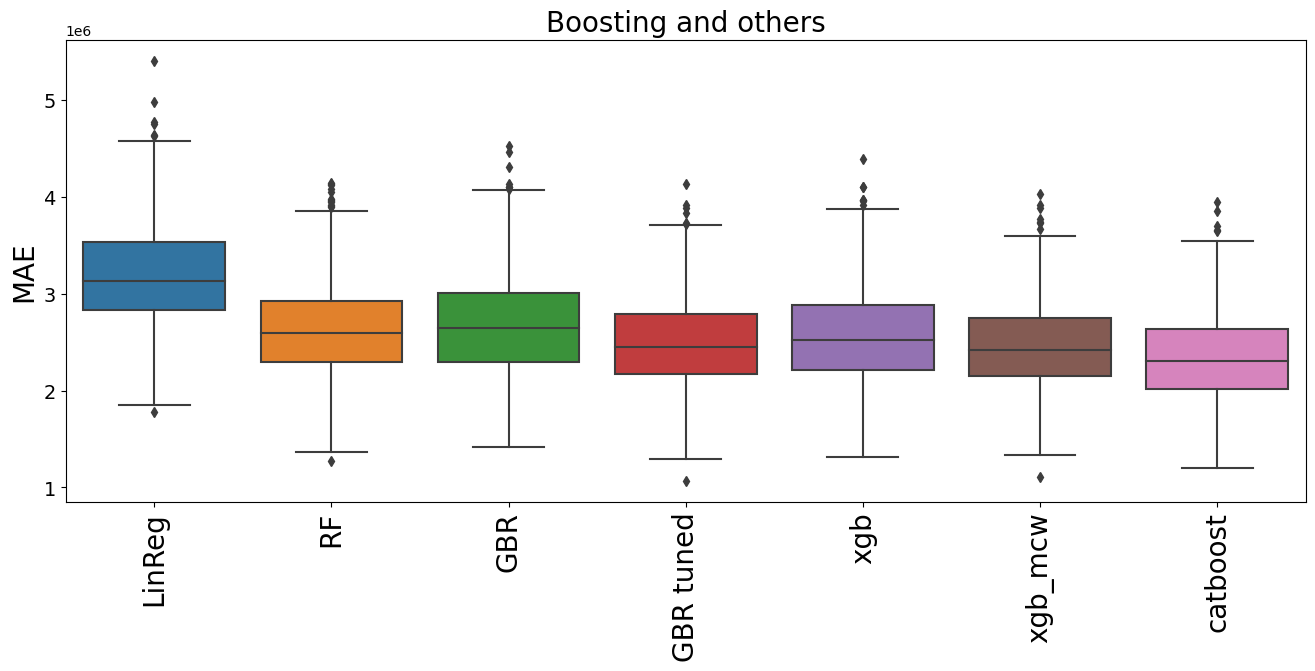

In [293]:
plt.figure(figsize=(16, 6))
ax = sns.boxplot(
    data=pd.concat([tuned_boost, xgb_add, xgb_add2, cat_add]),
    y="mae",
    x="model",
)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("MAE", size=20)
plt.title("Boosting and others", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.xticks(size=20)
plt.show()